# 1. Importing Libraries

In [72]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, plot_confusion_matrix, PrecisionRecallDisplay, auc, make_scorer, matthews_corrcoef
from statsmodels.stats.diagnostic import lilliefors
import math
from feature_engine import transformation as vt
from matplotlib.colors import ListedColormap
from boruta import BorutaPy
from sklearn import tree
import plotly.express as px

# 2. Reading Data

In [73]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df



def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#for the testing purporse, trim to remain first 100 rows only
X = read_features()
y = read_target().iloc[:,0]

# 3. Splitting Training & Testing Data

In [74]:
#Splitting the Data: 80% Training, 20% Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

# 4. Reducing Dimensionality

## 4.1. Remove duplicated Columns

In [75]:
#Function for finding and removing duplicated columns (features)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

In [76]:
#Using Function on x_train & printing new shape of dataframe after transformation 
X_train = remove_duplicated_columns(X_train)
X_train.shape

(1253, 486)

## 4.2. Removing Features with Constant Volatility

In [77]:
#Defining function to find and remove features with zero standard deviation 
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

In [78]:
#Using Function on x_train & printing new shape of dataframe after transformation 
X_train = remove_constant_volatility(X_train)
X_train.shape

(1253, 474)

## 4.3. Remove Features with high % of Missing Values

In [79]:
#Defining function to remove features with a given % of missing values 
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

In [80]:
#Using Function on X_train & printing new shape of dataframe after transformation 
X_train = remove_cols_with_high_pct_null(X_train, 0.7)
X_train.shape

(1253, 466)

# 5. Outlier & Missing Value Treatment

In [81]:
#Definition of Functiom
def outlier_clamp(df):
    for col in df.columns:
        ll_col = df[col].mean() - 2 * df[col].std()
        ul_col = df[col].mean() + 2 * df[col].std()
        df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

In [82]:
X_train = outlier_clamp(X_train)

In [83]:
#KNN only distance
def knndistance(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation 
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [84]:
X_train = knndistance(X_train)

# 6. Feature Selection

In [85]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [86]:
#Using Boruta Shap on x_train
X_train = BorutaShap_FS(X_train,y_train,'shap')

  0%|          | 0/100 [00:00<?, ?it/s]

In [87]:
#Shape of x_train after Feature Selection
X_train.shape

(1253, 18)

# 7. Multicolinearity Treatment

In [88]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):


    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [89]:
X_train=remove_collinear_features(X_train, 0.7)
X_train.shape

(1253, 13)

Text(0.5, 1.0, 'Correlation of remaining Features')

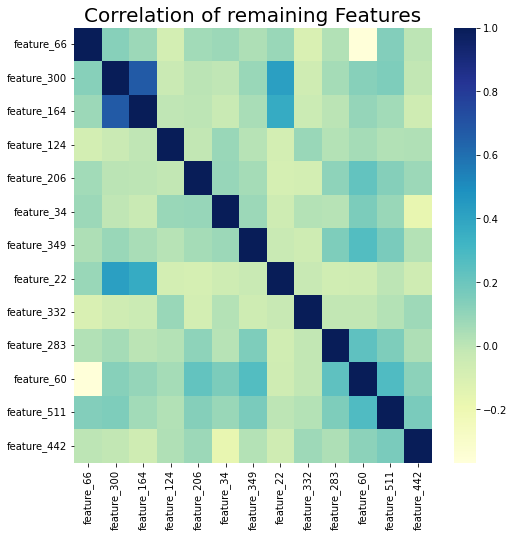

In [90]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(X_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 8. Balancing

In [91]:
#Function SMOTEENN
def sampling(x_train, y_train):
    sampler = SMOTEENN(random_state=100)
    X_resampled, y_resampled = sampler.fit_resample(x_train, y_train)
    return X_resampled, y_resampled

In [92]:
#Using Balancing Function on Train Data
X_train, y_train = sampling(X_train, y_train)

# 9. Modeling on Train Data

In [93]:
#Turning y_train to categorical, since Naive Bayes works better on categorical data
y_train = pd.Categorical(y_train)
y_train = pd.DataFrame(y_train)

In [94]:
#Model and Model Evaluation
gnb = GaussianNB(var_smoothing=1)
gnb.fit(X_train, y_train)
# make predictions
expected = y_train
predicted = gnb.predict(X_train)
# summarize the fit of the gnb
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


              precision    recall  f1-score   support

          -1       0.59      0.25      0.36       679
           1       0.61      0.87      0.72       919

    accuracy                           0.61      1598
   macro avg       0.60      0.56      0.54      1598
weighted avg       0.60      0.61      0.56      1598

[[173 506]
 [119 800]]


# 10. Model Testing  on Test Data Before Grid Search & Cross Validation

In [95]:
#1. Remove Duplicated Columns 
X_test = remove_duplicated_columns(X_test)
X_test.shape

(314, 480)

In [96]:
#2. Remove Constant Volalitily
X_test = remove_constant_volatility(X_test)
X_test.shape

(314, 468)

In [97]:
#3. Remove High % of NA
X_test = remove_cols_with_high_pct_null(X_test, 0.7)
X_test.shape

(314, 460)

In [98]:
#4. Treat Outliers and Missing Values
X_test = outlier_clamp(X_test)
X_test = knndistance(X_test)

In [99]:
#5. Take the same Columns as in train data 
columns_list = X_train.columns
X_test = X_test.loc[:,columns_list]
X_test.shape

(314, 13)

In [100]:
#6. Change Target Variable to Categorical
y_test = pd.Categorical(y_test)
y_test = pd.DataFrame(y_test)

In [101]:
#7. Modeling
exp_test = y_test
pred_test = gnb.predict(X_test)
# summarize the fit of the gnb
print(metrics.classification_report(exp_test, pred_test))
print(metrics.confusion_matrix(exp_test, pred_test))

              precision    recall  f1-score   support

          -1       0.93      0.23      0.37       293
           1       0.07      0.76      0.12        21

    accuracy                           0.27       314
   macro avg       0.50      0.50      0.25       314
weighted avg       0.87      0.27      0.35       314

[[ 68 225]
 [  5  16]]


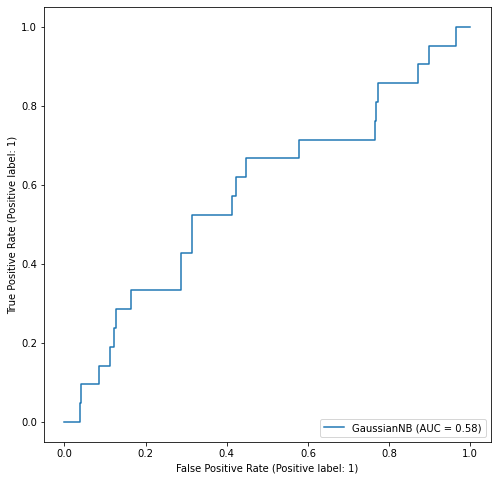

In [102]:
# ROC curve of Test Data 
metrics.RocCurveDisplay.from_estimator(gnb, X_test, y_test)
plt.show()

# 11. Grid Search & Cross Validation

## 11.1. Grid Search

In [103]:
def mcc_score(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    return mcc

In [104]:
#Gridsearch
##Define Grid Search Parameters 
scoring = {"Accuracy": make_scorer(accuracy_score), "Recall" : make_scorer(recall_score), "Auc": make_scorer(roc_auc_score), "Precision": make_scorer(precision_score), "mcc" : make_scorer(mcc_score,greater_is_better=True)}
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
cv = StratifiedKFold(n_splits=5)
#Hyperparameter Tune using Training Data 
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=cv,  n_jobs=-1, scoring=scoring, refit="Auc")
nbModel_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arasdirekoglu/opt/anaconda3/envs/dscience/lib/python3.9/site-packages/sklearn/utils/validatio

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e...
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             refit='Auc',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'Auc': make_scorer(roc_auc_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score),
                      'mcc': make_scorer(mcc_score)},
             verbose=1)

In [105]:
#Print Best estimator
print(nbModel_grid.best_estimator_, "is the best estimator")

GaussianNB(var_smoothing=2.848035868435799e-05) is the best estimator


In [106]:
#Data Frame Grid Search Results 
gridsearchNB = pd.DataFrame(nbModel_grid.cv_results_)

In [107]:
#Calculating Cost for each var_smoothing
cl_list = ['param_var_smoothing','mean_test_Precision', 'mean_test_Recall', 'mean_test_Accuracy']
cost_df = gridsearchNB.loc[:, cl_list]
cost_df['type2_error'] = cost_df['mean_test_Recall'].apply(lambda x: 21 - (21 * x))
cost_df['type2_error'] = cost_df['type2_error'] #.round(decimals = 0 )
cost_df['type1_error'] = cost_df.apply(lambda row: ((21 - row.type2_error) / row.mean_test_Precision) - (21-row.type2_error), axis=1)
cost_df['type1_error'] = cost_df['type1_error'] #.round(decimals = 0 )
cost_df['costs'] = cost_df.apply(lambda row: row.type2_error * 10 + row.type1_error, axis=1)

In [119]:
#3D Scatter Costs, Recall & Precision
fig = px.scatter_3d(cost_df, z='costs', y='mean_test_Recall', x='mean_test_Precision', color='costs', size='costs')
fig.show()

In [120]:
#3D Scatter Costs, Recall & Var_smoothing
fig = px.scatter_3d(cost_df, z='param_var_smoothing', x='mean_test_Recall', y='mean_test_Precision',
                    labels={"param_var_smoothing": "Hyperparameter",
                            "mean_test_Recall": "Recall",
                            "mean_test_Precision": "Precision"},
                        color='costs', size='costs'
                        )
fig.show()

## 11.2. Cross Validation

In [110]:
# Evaluation using Startified K Fold cross validation and printing mean scores
cv = StratifiedKFold(n_splits=20)
print("mean Recall")
scores = cross_val_score(nbModel_grid.best_estimator_, X_train, y_train, cv=cv, scoring = 'recall')
print(scores.mean())
print("mean accuracy")
accuracycv = cross_val_score(nbModel_grid.best_estimator_, X_train, y_train, cv=cv, scoring = 'accuracy') 
print(accuracycv.mean())
print("mean auc")
auccv = cross_val_score(nbModel_grid.best_estimator_, X_train, y_train, cv=cv, scoring = 'roc_auc') 
print(auccv.mean())
print("mean precision")
preccv = cross_val_score(nbModel_grid.best_estimator_, X_train, y_train, cv=cv, scoring = 'precision') 
print(preccv.mean())

mean Recall
0.6735507246376812
mean accuracy
0.7471598101265823
mean auc
0.8235250846056473
mean precision
0.8578500792012465


In [111]:
#Creating a Dataframe out of CV Results to calculate Costs
scores_df = pd.DataFrame(scores, columns=['recall_scores'])
acc_df = pd.DataFrame(accuracycv, columns=['accuracy_scores'])
auc_df = pd.DataFrame(auccv, columns = ['auc_scores'])
prec_df =pd.DataFrame(preccv, columns = ['precision_scores']) 
cv_scores_df = pd.concat([scores_df, acc_df, auc_df, prec_df], axis=1)
cv_scores_df['type2_error'] = cv_scores_df['recall_scores'].apply(lambda x: 21 - (21 * x))
cv_scores_df['type2_error'] = cv_scores_df['type2_error'].round(decimals = 0 )
cv_scores_df['type1_error'] = cv_scores_df.apply(lambda row: ((21 - row.type2_error) / row.precision_scores) - (21-row.type2_error), axis=1)
cv_scores_df['type1_error'] = cv_scores_df['type1_error'].round(decimals = 0 )
cv_scores_df['costs'] = cv_scores_df.apply(lambda row: row.type2_error * 10 + row.type1_error, axis=1)

<AxesSubplot:xlabel='recall_scores', ylabel='precision_scores'>

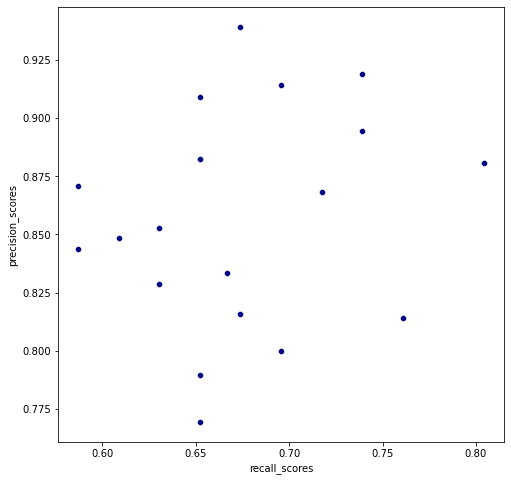

In [112]:
#Crossvalidation Vizualization Recall & Acccuracy
sns.scatterplot(data=cv_scores_df, x='recall_scores', y='precision_scores', color="navy")

# 12. Final Modeling & Testing on Test Data 

In [113]:
# fit
nb=nbModel_grid.best_estimator_.fit(X_train, y_train)    
# predict
y_pred_test = nb.predict(X_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)
# View accuracy score
RecallFinal = recall_score(y_test, y_pred_test)
print('Test Recall : ', RecallFinal)
PrecisionFinal = precision_score(y_test, y_pred_test)
print('Test Precision : ', PrecisionFinal)

Test Accuracy :  0.7707006369426752
Test Recall :  0.7142857142857143
Test Precision :  0.18518518518518517


In [114]:
#Confusion Matrix & Classification Report of best estimator
print(metrics.confusion_matrix(y_test, y_pred_test))
print(metrics.classification_report(y_test, y_pred_test))

[[227  66]
 [  6  15]]
              precision    recall  f1-score   support

          -1       0.97      0.77      0.86       293
           1       0.19      0.71      0.29        21

    accuracy                           0.77       314
   macro avg       0.58      0.74      0.58       314
weighted avg       0.92      0.77      0.83       314



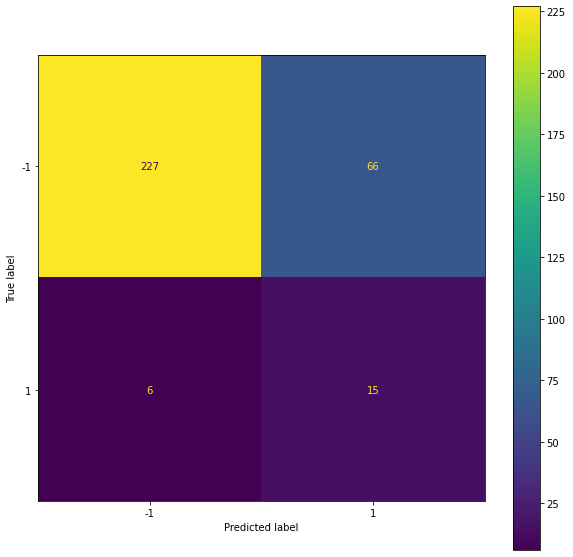

In [115]:
# Plot confussion matrix
plt.rcParams['figure.figsize'] = (10, 10)
cm = confusion_matrix(y_test, y_pred_test, labels=nbModel_grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nbModel_grid.best_estimator_.classes_)
disp.plot()
plt.show()

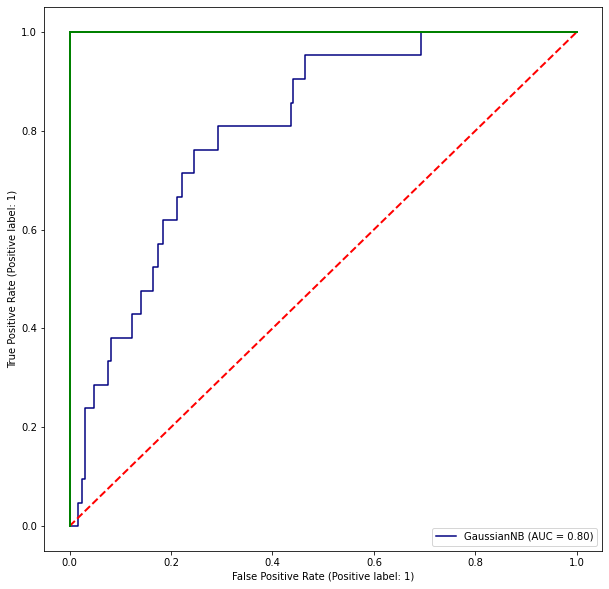

In [116]:
# ROC curve
plt.rcParams['figure.figsize'] = (10, 10)
metrics.RocCurveDisplay.from_estimator(nbModel_grid.best_estimator_, X_test, y_test, color="navy")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.plot([0, 0], [1, 0], color="green", lw=2, linestyle="-")
plt.plot([1, 0], [1, 1], color="green", lw=2, linestyle="-")
plt.show()

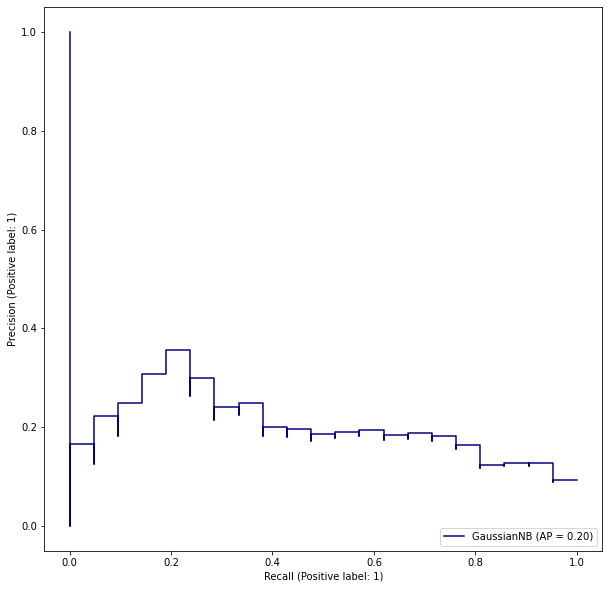

In [117]:
#Precision / Recall
metrics.PrecisionRecallDisplay.from_estimator(nbModel_grid.best_estimator_, X_test, y_test, color="navy")
plt.legend(loc="lower right")
plt.show()